<a href="https://colab.research.google.com/github/BoKna031/Image_inpainting/blob/master/Image_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Kaggle dataset

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d amanara/photos

Dataset URL: https://www.kaggle.com/datasets/amanara/photos
License(s): unknown
photos.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip photos.zip;

Archive:  photos.zip
replace Dataset/Testing_Data/Cat-Train (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Data preparation

In [4]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

TRAIN = 'Train'
TEST = 'Test'
img_size = (64, 64)

def load_training_dataset(category):
  TRAINING_DATA_FOLDER = os.path.join('Dataset', 'Training_Data', category)
  x_doc = os.path.join('Dataset', 'Training_Data', category, 'Masked_Train')
  x_imgs = _load_images_from_folder(x_doc, category, TRAIN)
  y_doc = os.path.join('Dataset', 'Training_Data', category, 'Unmasked_Train')
  y_imgs = _load_images_from_folder(y_doc, category, TRAIN)
  csv_file = pd.read_csv(os.path.join(TRAINING_DATA_FOLDER, 'masked_info.csv'))
  adjust_box_coordinate(csv_file)
  return x_imgs, y_imgs, csv_file

def adjust_box_coordinate(csv_df):
  ORG_IMG_SIZE = (256,256)
  scale_xy = img_size[0] / ORG_IMG_SIZE[0]
  csv_df[['box1_row', 'box1_col', 'box2_row', 'box2_col']] = (csv_df[['box1_row', 'box1_col', 'box2_row', 'box2_col']] * scale_xy).astype(int)


def _load_images_from_folder(folder, category, set_type):
    images = []
    for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.resize(img, img_size)
            if img is not None:
              id, format = _parse_filename(filename)
              images.append({'filename': filename, 'category': category, 'id': id, 'set_type': set_type, 'format': format, 'image': img})
    images_df = pd.DataFrame(images, columns=['filename', 'category', 'id', 'set_type', 'format', 'image'])
    return images_df

import re

def _parse_filename(filename):
    regex_pattern = r'.*\((\d+)\)\.(\w+)$'

    match = re.match(regex_pattern, filename)

    if match:
        id = int(match.group(1))
        format =  match.group(2)
        return id, format
    else:
        return  None, None

def show_img(img, gray = False):
  if gray:
    plt.imshow(img, 'gray')
  else:
    plt.imshow(img)
  plt.axis('off')
  plt.show()


In [5]:
categories = ['Cat', 'Dog', 'Elephant', 'Tiger']

# Data analyzing

In [6]:
category = categories[0]
_, y, csv = load_training_dataset(category)
x_size = y['image'].apply(lambda img: pd.Series({'rows':img.shape[0], 'cols': img.shape[1]})).groupby(['rows','cols']).size()
print(f"{category}\n---------------------------")
print("total size = ",y.shape[0])
print(x_size)

Cat
---------------------------
total size =  1750
rows  cols
64    64      1750
dtype: int64


From the shown, it can be seen that all the images are of size 168x168

array([[[133, 114,   3],
        [134, 116,   3],
        [135, 117,   2],
        ...,
        [131, 117,   9],
        [131, 117,   9],
        [131, 117,   9]],

       [[134, 115,   4],
        [135, 117,   4],
        [135, 117,   2],
        ...,
        [135, 119,   9],
        [135, 119,   9],
        [135, 119,   9]],

       [[134, 115,   4],
        [136, 118,   5],
        [136, 118,   3],
        ...,
        [137, 119,   8],
        [137, 119,   8],
        [137, 119,   8]],

       ...,

       [[149, 134,   9],
        [148, 132,   8],
        [148, 133,   8],
        ...,
        [158, 143,   9],
        [160, 146,  12],
        [163, 148,  15]],

       [[148, 133,   7],
        [148, 133,   7],
        [147, 132,   6],
        ...,
        [156, 140,   4],
        [157, 141,   4],
        [163, 147,  10]],

       [[146, 132,   2],
        [146, 132,   2],
        [147, 133,   3],
        ...,
        [156, 137,   5],
        [157, 138,   6],
        [163, 144,  12]]], dtype=uint8)
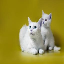

In [7]:
y.iloc[0]['image']

In [8]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col
0,0,Cat-Train (1085).jpeg,16,1,10,38
1,1,Cat-Train (900).jpeg,21,5,26,41
2,2,Cat-Train (1759).jpeg,15,24,0,35
3,3,Cat-Train (969).jpeg,3,34,11,34
4,4,Cat-Train (1559).jpeg,26,23,10,39


In [9]:
box_size = [15, 15]

def is_within_bounds(row, col):
  return row + box_size[0] <= img_size[0] and col + box_size[1] <= img_size[1]

In [10]:
csv['box1_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box1_row'], row['box1_col']), axis=1)
csv['box2_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box2_row'], row['box2_col']), axis=1)
invalid_boxes = csv[(~csv['box1_within_bounds']) | (~csv['box2_within_bounds'])]

In [11]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col,box1_within_bounds,box2_within_bounds
0,0,Cat-Train (1085).jpeg,16,1,10,38,True,True
1,1,Cat-Train (900).jpeg,21,5,26,41,True,True
2,2,Cat-Train (1759).jpeg,15,24,0,35,True,True
3,3,Cat-Train (969).jpeg,3,34,11,34,True,True
4,4,Cat-Train (1559).jpeg,26,23,10,39,True,True


In [12]:
print(f"There is {invalid_boxes.shape[0]} images that have invalid boxes")

There is 0 images that have invalid boxes


In [13]:
x_cp = y.copy(deep=True)

In [14]:
import numpy as np
def draw_masks(image, csv_row , box_size):
    col1, row1, col2, row2 = csv_row['box1_row'], csv_row['box1_col'], csv_row['box2_row'], csv_row['box2_col']
    mask = np.zeros(img_size)
    mask[row1:row1+box_size[0], col1:col1+box_size[1]] = 1
    #mask[row2:row2+box_size[0], col2:col2+box_size[1]] = 1
    img_cp = image.copy()
    img_cp[mask==1] = 0
    mask = mask[:, :, np.newaxis]
    rgbm_image = np.concatenate((img_cp, mask), axis=2).astype(np.int32)
    return rgbm_image

In [15]:
x_cp['image'] = x_cp.apply(lambda row: draw_masks(row['image'], csv[csv['filename'] == row['filename']].iloc[0], box_size), axis = 1)

In [16]:
type(x_cp.iloc[0]['image'])

numpy.ndarray

In [17]:
merged_data = pd.merge(x_cp, csv, on='filename')
merged_data = pd.merge(merged_data, y, on = 'filename')

In [18]:
final_table_columns = ['filename', 'image_x', 'image_y', 'box2_row', 'box2_col']
train_df = merged_data.drop(columns=[col for col in merged_data if col not in final_table_columns])

In [19]:
#train_df.head()

In [20]:
test_row = train_df.iloc[3]
x_coord, y_coord = test_row['box2_row'], test_row['box2_col']
print(x_coord, y_coord)

17 26


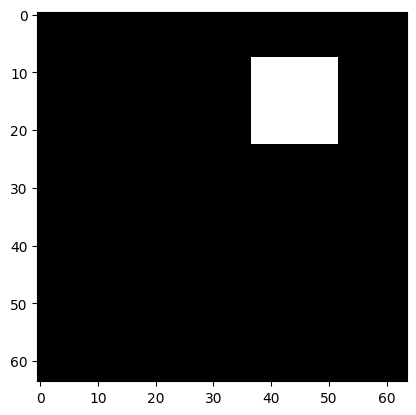

In [21]:
plt.imshow(test_row['image_x'][:,:,3], cmap='gray')
plt.show()

In [22]:
def crop_box(rgbm, y_img):
  mask = rgbm[:,:,3]
  rows, cols = np.where(mask == 1)

  min_row, max_row = np.min(rows), np.max(rows)
  min_col, max_col = np.min(cols), np.max(cols)

  return y_img[min_row:max_row + 1, min_col:max_col + 1, :]


In [23]:
train_df['image_y'] = train_df.apply(lambda row: crop_box(row['image_x'], row['image_y']), axis = 1)

In [24]:
train_df.iloc[1]['image_y']

array([[[159, 165, 190],
        [157, 163, 188],
        [153, 159, 185],
        [161, 166, 194],
        [185, 191, 205],
        [200, 203, 214],
        [  5,   5,  20],
        [ 13,   9,  33],
        [ 17,  14,  36],
        [  7,   5,  27],
        [  4,   2,  24],
        [  3,   0,  22],
        [  1,   1,  21],
        [  4,   3,  23],
        [  5,   2,  22]],

       [[158, 162, 187],
        [155, 159, 185],
        [149, 153, 180],
        [159, 163, 191],
        [178, 183, 199],
        [192, 195, 205],
        [118, 120, 131],
        [ 21,  19,  38],
        [ 17,  18,  39],
        [  6,   7,  28],
        [  3,   4,  25],
        [  2,   3,  24],
        [  4,   4,  24],
        [  4,   3,  23],
        [  5,   1,  22]],

       [[161, 156, 185],
        [163, 160, 185],
        [178, 176, 196],
        [171, 171, 186],
        [181, 185, 202],
        [178, 181, 191],
        [221, 223, 232],
        [ 62,  61,  75],
        [ 67,  69,  89],
        [ 19,  22,  41],
        [  1,   2,  21],
        [ 11,  14,  33],
        [ 13,  13,  33],
        [ 10,   9,  29],
        [  5,   1,  22]],

       [[158, 158, 181],
        [179, 178, 198],
        [192, 190, 205],
        [174, 173, 184],
        [160, 167, 185],
        [167, 172, 185],
        [188, 190, 199],
        [208, 208, 214],
        [166, 168, 180],
        [ 93,  94, 104],
        [ 78,  77,  87],
        [117, 116, 123],
        [ 89,  80,  94],
        [ 39,  33,  46],
        [ 73,  70,  83]],

       [[145, 143, 173],
        [142, 138, 166],
        [176, 172, 194],
        [183, 179, 199],
        [163, 167, 182],
        [174, 178, 190],
        [182, 184, 194],
        [201, 204, 211],
        [197, 199, 207],
        [204, 204, 211],
        [202, 201, 205],
        [219, 215, 219],
        [209, 207, 212],
        [216, 216, 221],
        [173, 173, 178]],

       [[142, 139, 171],
        [142, 138, 168],
        [166, 161, 186],
        [139, 134, 155],
        [185, 185, 198],
        [172, 174, 185],
        [178, 183, 193],
        [177, 183, 193],
        [186, 193, 201],
        [201, 205, 213],
        [193, 196, 201],
        [202, 205, 210],
        [219, 224, 226],
        [202, 206, 208],
        [212, 214, 217]],

       [[143, 141, 170],
        [138, 135, 160],
        [157, 154, 174],
        [157, 153, 171],
        [160, 159, 169],
        [158, 159, 169],
        [162, 167, 178],
        [163, 171, 184],
        [153, 166, 181],
        [170, 182, 195],
        [169, 179, 190],
        [196, 205, 215],
        [206, 213, 219],
        [210, 215, 221],
        [210, 211, 218]],

       [[139, 135, 163],
        [133, 130, 154],
        [135, 134, 153],
        [161, 160, 176],
        [151, 152, 166],
        [164, 167, 178],
        [167, 174, 183],
        [153, 164, 171],
        [165, 179, 189],
        [156, 168, 177],
        [145, 156, 163],
        [194, 204, 211],
        [195, 203, 212],
        [213, 211, 222],
        [204, 199, 210]],

       [[129, 129, 154],
        [146, 148, 169],
        [137, 140, 157],
        [137, 141, 154],
        [141, 149, 162],
        [138, 148, 158],
        [154, 166, 174],
        [145, 159, 165],
        [150, 161, 170],
        [200, 210, 218],
        [143, 151, 157],
        [193, 201, 205],
        [210, 216, 223],
        [219, 221, 229],
        [199, 200, 208]],

       [[131, 137, 158],
        [134, 141, 159],
        [132, 140, 153],
        [139, 149, 158],
        [142, 154, 166],
        [140, 151, 161],
        [132, 142, 151],
        [168, 178, 185],
        [184, 191, 199],
        [201, 207, 213],
        [183, 186, 190],
        [195, 199, 201],
        [204, 208, 213],
        [215, 221, 226],
        [207, 214, 219]],

       [[130, 141, 160],
        [130, 142, 157],
        [136, 149, 160],
        [137, 152, 158],
        [141, 149, 162],
        [142, 148, 159],
        [164, 167, 177],
        [180, 182, 190],
        [138, 142, 147],
     

# Networks

In [25]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, Reshape
from tensorflow.keras.models import Sequential

## CNN

In [26]:
euclidean_model_1 = Sequential()

euclidean_model_1.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(img_size[0], img_size[1], 4)))
for i in range(9):
  if (i + 1) % 3 == 0:
     euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu'))
  else:
    euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

euclidean_model_1.add(Flatten())
euclidean_model_1.add(Dense(box_size[0]*box_size[1]*3, activation='relu'))
euclidean_model_1.add(Activation('sigmoid'))
euclidean_model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [27]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

def lr_schedule(epoch):
  model = euclidean_model_1 #change before model fit
  lr = K.get_value(model.optimizer.lr)
  if epoch % 5 == 0 and epoch > 0:
      K.set_value(model.optimizer.lr, lr * 0.8)
      print(f"Learning rate reduced to: {lr * 0.8}")
  return K.get_value(model.optimizer.lr)

batch_size = 64
weight_decay = 0.005
lr_scheduler = LearningRateScheduler(lr_schedule)

In [28]:
#train_df.iloc[0]['image_x']

In [29]:
print(type(train_df.iloc[0]['image_y']))
print(train_df.iloc[0]['image_y'].shape)

<class 'numpy.ndarray'>
(15, 15, 3)


In [30]:
lr_scheduler = LearningRateScheduler(lr_schedule)
batch_size = 16
epochs = 5

In [31]:
X_train = np.stack(train_df['image_x'].values)
y_train = np.stack(train_df['image_y'].values)
y_train = y_train.reshape(y_train.shape[0],box_size[0]*box_size[1]*3)

In [32]:
history = euclidean_model_1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[lr_scheduler],
    validation_split=0.2
)



Epoch 1/5
88/88 [==============================] - 122s 1s/step - loss: 23776.5801 - mae: 136.9262 - val_loss: 22644.8867 - val_mae: 133.4474 - lr: 0.0010
Epoch 2/5
88/88 [==============================] - 121s 1s/step - loss: 23771.9141 - mae: 136.9090 - val_loss: 22644.5547 - val_mae: 133.4462 - lr: 0.0010
Epoch 3/5
88/88 [==============================] - 120s 1s/step - loss: 23771.8438 - mae: 136.9089 - val_loss: 22644.5547 - val_mae: 133.4462 - lr: 0.0010
Epoch 4/5
88/88 [==============================] - 117s 1s/step - loss: 23771.8477 - mae: 136.9089 - val_loss: 22644.5547 - val_mae: 133.4462 - lr: 0.0010
Epoch 5/5
88/88 [==============================] - 125s 1s/step - loss: 23771.8438 - mae: 136.9088 - val_loss: 22644.5547 - val_mae: 133.4462 - lr: 0.0010


In [33]:
import pickle

def save_history(history, path):
  with open(path, 'wb') as f:
    pickle.dump(history, f)

In [34]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CNN/trained-models"
HISTORY_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CNN/history"

In [35]:
euclidean_model_1.save(MODEL_PATH + "/euclidean_model_1.keras")
save_history(history.history, HISTORY_PATH + "/euclidean_model_64_history.pkl")

# Monitoring - History of loss function

In [36]:
def load_history(path):
  with open(path, "rb") as file:
    return pickle.load(file)

In [37]:
h1 = load_history(HISTORY_PATH + "/euclidean_model_64_history.pkl")

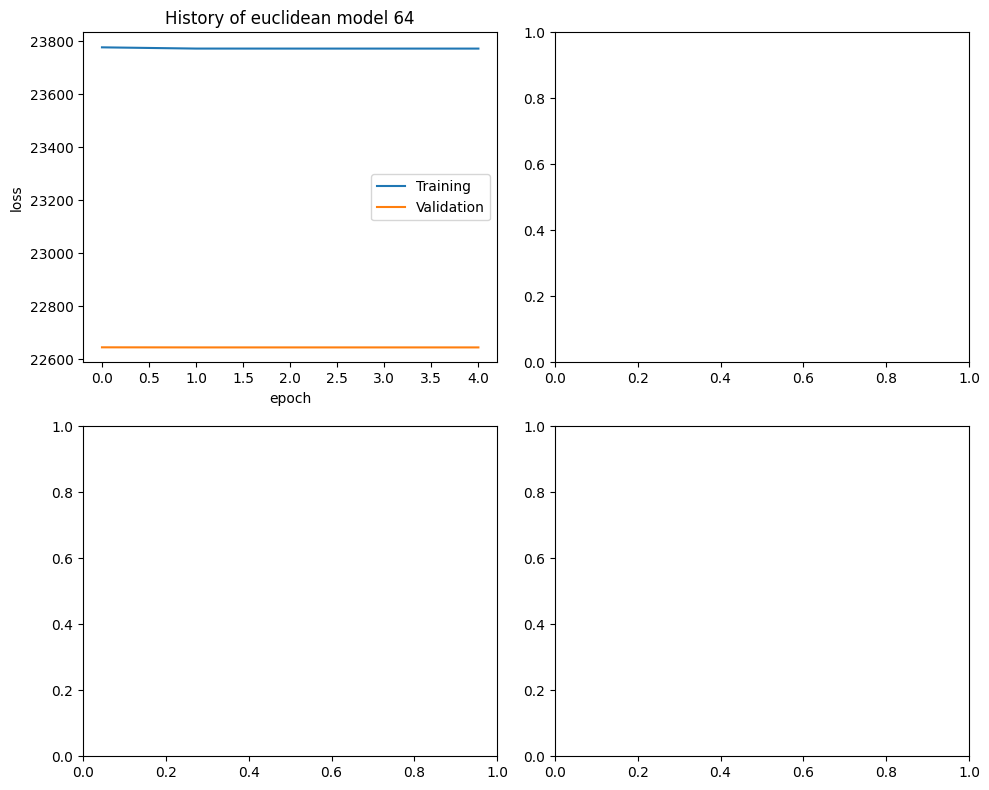

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(h1['loss'])
axes[0, 0].plot(h1['val_loss'])
axes[0, 0].set_title('History of euclidean model 64')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')
axes[0, 0].legend(['Training', 'Validation'])
plt.tight_layout()
plt.show()

# Predictions

In [39]:
from keras.models import load_model

euc1_model = load_model(MODEL_PATH + "/euclidean_model_1.keras")

In [40]:
def full_image(nb_img, center):
  modified_image = np.copy(nb_img)
  center_x = nb_img.shape[0] // 2
  center_y = nb_img.shape[1] // 2
  modified_image[center_x-5:center_x+5, center_y-5:center_y+5, :] = center

  return modified_image


def load_testing_dataset():
  TESTING_DATA_FOLDER = os.path.join('Dataset', 'Testing_Data')
  test_data = []

  csv_file = pd.read_csv(os.path.join(TESTING_DATA_FOLDER, 'masked_info.csv'))
  adjust_box_coordinate(csv_file)

  for filename in os.listdir(TESTING_DATA_FOLDER):
    if filename.endswith('.csv'):
            continue
    img = cv2.imread(os.path.join(TESTING_DATA_FOLDER, filename))
    img = cv2.resize(img, img_size)
    img_rgbm = draw_masks(img, csv_file[csv_file['filename'] == filename].iloc[0], box_size)
    test_data.append(img_rgbm)
  return test_data

In [41]:
#data = load_testing_dataset()[0:5]

In [57]:
x = X_train[0:5]

In [42]:
x = np.stack(data)

In [58]:
pred = euc1_model.predict(x)

1/1 [==============================] - 0s 105ms/step


In [51]:
data[0].shape

(64, 64, 4)

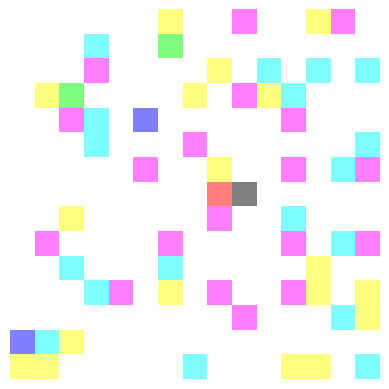

In [59]:
show_img(np.reshape(pred[4], (15, 15, 3)))

In [52]:
def full_image(x_rgbm_img, y_img):
  modified_image = np.copy(x_rgbm_img[:, :, :3])
  y_img_255 = y_img * 255
  mask = x_rgbm_img[:,:,3]

  coords = np.argwhere(mask == 1)

  x_min = np.min(coords[:, 0])
  y_min = np.min(coords[:, 1])

  modified_image[x_min:x_min+15, y_min:y_min+15, :] = y_img_255

  return modified_image

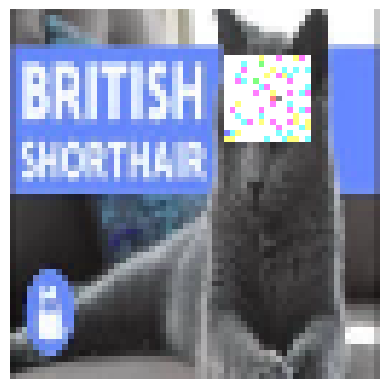

In [64]:
show_img(full_image(x[3],np.reshape(pred[3], (15, 15, 3))))